# Experiment setup
- Go to the root folder, run `mkdir ./results` and `mkdir ./data` to create folders for saving experiment results and training data respectively.
- Download data from [google drive link](https://drive.google.com/drive/folders/1qrFuQOxrbaDziJFeEkpAiXmL_C8dlk3K?usp=sharing), and put the training data into folder `./data`.

# Start experiment
- "sgcn_pplus_0" refers to the zeroth-order only
- "sgcn_pplus_1" refers to the first-order only
- "sgcn_pplus_01" refers to the doubly variance reduction

In [1]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
"""
Import necessary packages
"""
from utils import *
import argparse
import multiprocessing as mp
from samplers import fastgcn_sampler, ladies_sampler, graphsage_sampler, exact_sampler, full_batch_sampler

# Change dataset, base model
- You can change the dataset `--dataset` by directly change it bellow 
- You can change the base model `--sample_method` by directly change it bellow

In [3]:
"""
Dataset arguments
"""
parser = argparse.ArgumentParser(
    description='Training GCN on Large-scale Graph Datasets')

parser.add_argument('--dataset', type=str, default='flickr',
                    help='Dataset name: pubmed/flickr/reddit/ppi')
parser.add_argument('--nhid', type=int, default=256,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default=200,
                    help='Number of Epoch')
parser.add_argument('--pool_num', type=int, default=10,
                    help='Number of Pool')
parser.add_argument('--batch_num', type=int, default=10,
                    help='Maximum Batch Number')
parser.add_argument('--batch_size', type=int, default=512,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=2,
                    help='Number of GCN layers')
parser.add_argument('--n_stops', type=int, default=200,
                    help='Early stops')
parser.add_argument('--samp_num', type=int, default=512,
                    help='Number of sampled nodes per layer (only for ladies & factgcn)')
parser.add_argument('--sample_method', type=str, default='ladies',
                    help='Sampled Algorithms: ladies/fastgcn/graphsage/exact')
parser.add_argument('--dropout', type=float, default=0,
                    help='Dropout rate')
parser.add_argument('--cuda', type=int, default=1,
                    help='Avaiable GPU ID')
parser.add_argument('--sgd_lr', type=int, default=0.7,
                    help='learning rate for SGD')
args = parser.parse_args()
print(args)

Namespace(batch_num=10, batch_size=512, cuda=1, dataset='flickr', dropout=0, epoch_num=200, n_layers=2, n_stops=200, nhid=256, pool_num=10, samp_num=512, sample_method='ladies', sgd_lr=0.7)


In [4]:
"""
Prepare devices
"""
if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")

"""
Prepare data using multi-process
"""


def prepare_data(pool, sampler, process_ids, train_nodes, samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth):
    jobs = []
    for _ in process_ids:
        batch_idx = torch.randperm(len(train_nodes))[:args.batch_size]
        batch_nodes = train_nodes[batch_idx]
        p = pool.apply_async(sampler, args=(np.random.randint(2**32 - 1), batch_nodes,
                                            samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth))
        jobs.append(p)
    return jobs


lap_matrix, labels, feat_data, train_nodes, valid_nodes, test_nodes = preprocess_data(
    args.dataset, True if args.sample_method=='graphsage' else False)
print("Dataset information")
print(lap_matrix.shape, labels.shape, feat_data.shape,
      train_nodes.shape, valid_nodes.shape, test_nodes.shape)

if type(feat_data) == sp.lil.lil_matrix:
    feat_data = torch.FloatTensor(feat_data.todense()).to(device)
else:
    feat_data = torch.FloatTensor(feat_data).to(device)

Removed 0 nodes that lacked proper annotations due to networkx versioning issues
Loaded data.. now preprocessing..
Dataset information
(89250, 89250) (89250,) (89250, 500) (44625,) (22312,) (22313,)


In [5]:
"""
Setup datasets and models for training (multi-class use sigmoid+binary_cross_entropy, use softmax+nll_loss otherwise)
"""
if args.dataset in ['cora', 'citeseer', 'pubmed', 'flickr', 'reddit']:
    from model import GCN
    from optimizers import spider_step, multi_level_step_v1, multi_level_step_v2, sgd_step, full_step
    from optimizers import ForwardWrapper, package_mxl
    labels = torch.LongTensor(labels).to(device)
    num_classes = labels.max().item()+1
elif args.dataset in ['ppi', 'ppi-large', 'amazon', 'yelp']:
    from model_mc import GCN
    from optimizers_mc import spider_step, multi_level_step_v1, multi_level_step_v2, sgd_step, full_step
    from optimizers_mc import ForwardWrapper, package_mxl
    labels = torch.FloatTensor(labels).to(device)
    num_classes = labels.shape[1]

if args.sample_method == 'ladies':
    sampler = ladies_sampler
    args.samp_num = 512
    samp_num_list = np.array([args.samp_num for _ in range(args.n_layers)])
elif args.sample_method == 'fastgcn':
    args.samp_num = 512
    sampler = fastgcn_sampler
    samp_num_list = np.array([args.samp_num for _ in range(args.n_layers)])
elif args.sample_method == 'exact':
    sampler = exact_sampler
    samp_num_list = np.array([args.samp_num for _ in range(args.n_layers)]) # never used
elif args.sample_method == 'graphsage':
    args.samp_num = 5
    sampler = graphsage_sampler
    samp_num_list = np.array([args.samp_num for _ in range(args.n_layers)])  # as proposed in GraphSage paper

In [6]:
def calculate_grad_variance(net, feat_data, labels, train_nodes, adjs_full):
    net_grads = []
    for p_net in net.parameters():
        net_grads.append(p_net.grad.data)
    clone_net = copy.deepcopy(net)
    _, _ = clone_net.calculate_loss_grad(
        feat_data, adjs_full, labels, train_nodes)

    clone_net_grad = []
    for p_net in clone_net.parameters():
        clone_net_grad.append(p_net.grad.data)
    del clone_net

    variance = 0.0
    for g1, g2 in zip(net_grads, clone_net_grad):
        variance += (g1-g2).norm(2) ** 2
    variance = torch.sqrt(variance)
    return variance

In [7]:
"""
This is a zeroth-order and first-order variance reduced version of Stochastic-GCN++
"""

def sgcn_pplus_01(feat_data, labels, lap_matrix, train_nodes, valid_nodes, test_nodes,  args, device, calculate_grad_vars=False):
    memory_allocated, max_memory_allocated = [], []
    
    # use multiprocess sample data
    process_ids = np.arange(args.batch_num)
    pool = mp.Pool(args.pool_num)
    lap_matrix_sq = lap_matrix.multiply(lap_matrix)
    jobs = prepare_data(pool, sampler, process_ids, train_nodes, samp_num_list, len(feat_data),
                        lap_matrix, lap_matrix_sq, args.n_layers)

    susage = GCN(nfeat=feat_data.shape[1], nhid=args.nhid, num_classes=num_classes,
                 layers=args.n_layers, dropout=args.dropout).to(device)
    susage.to(device)
    
    print(susage)

    adjs_full, input_nodes_full, sampled_nodes_full = full_batch_sampler(
        train_nodes, len(feat_data), lap_matrix, args.n_layers)
    adjs_full = package_mxl(adjs_full, device)

    forward_wrapper = ForwardWrapper(
        len(feat_data), args.nhid, args.n_layers, num_classes)

#     optimizer = optim.SGD(filter(lambda p : p.requires_grad, susage.parameters()), lr=args.sgd_lr)
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, susage.parameters()))

    best_model = copy.deepcopy(susage)
    best_val_loss, _ = susage.calculate_loss_grad(feat_data, adjs_full, labels, valid_nodes)
    cnt = 0
    
    loss_train = [best_val_loss]
    loss_test = [best_val_loss]
    grad_variance_all = []
    loss_train_all = [best_val_loss]

    for epoch in np.arange(args.epoch_num):
        memory_allocated += [torch.cuda.memory_allocated(device)/1024/1024]
        max_memory_allocated += [torch.cuda.max_memory_allocated(device)/1024/1024]
        
        # fetch train data
        train_data = [job.get() for job in jobs]
        pool.close()
        pool.join()
        # prepare next epoch train data
        pool = mp.Pool(args.pool_num)
        jobs = prepare_data(pool, sampler, process_ids, train_nodes, samp_num_list, len(feat_data),
                            lap_matrix, lap_matrix_sq, args.n_layers)

        inner_loop_num = args.batch_num
        calculate_grad_vars = calculate_grad_vars and epoch<20
        cur_train_loss, cur_train_loss_all, grad_variance = multi_level_step_v2(susage, optimizer, feat_data, labels,
                                                                        train_nodes, valid_nodes, adjs_full, sampled_nodes_full,
                                                                        train_data, inner_loop_num, forward_wrapper, device, dist_bound=2e-3, #2e-4
                                                                        calculate_grad_vars=calculate_grad_vars)
        loss_train_all.extend(cur_train_loss_all)
        grad_variance_all.extend(grad_variance)
        # calculate validate loss
        susage.eval()

        susage.zero_grad()
        val_loss, _ = susage.calculate_loss_grad(
            feat_data, adjs_full, labels, valid_nodes)

        if val_loss < best_val_loss:
            best_model = copy.deepcopy(susage)
        if val_loss + 0.01 < best_val_loss:
            best_val_loss = val_loss
            cnt = 0
        else:
            cnt += 1
            
        if cnt == args.n_stops//args.batch_num:
            break

        cur_test_loss = val_loss

        loss_train.append(cur_train_loss)
        loss_test.append(cur_test_loss)
        
        # print progress
        print('Epoch: ', epoch,
              '| train loss: %.8f' % cur_train_loss,
              '| test loss: %.8f' % cur_test_loss)
    
    f1_score_test = best_model.calculate_f1(feat_data, adjs_full, labels, test_nodes)
    return best_model, loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated

In [8]:
"""
This is a first-order variance reduced version of Stochastic-GCN++
"""

def sgcn_pplus_1(feat_data, labels, lap_matrix, train_nodes, valid_nodes, test_nodes,  args, device, calculate_grad_vars=False):
    memory_allocated, max_memory_allocated = [], []
    
    # use multiprocess sample data
    process_ids = np.arange(args.batch_num)
    pool = mp.Pool(args.pool_num)
    lap_matrix_sq = lap_matrix.multiply(lap_matrix)
    jobs = prepare_data(pool, sampler, process_ids, train_nodes, samp_num_list, len(feat_data),
                        lap_matrix, lap_matrix_sq, args.n_layers)

    susage = GCN(nfeat=feat_data.shape[1], nhid=args.nhid, num_classes=num_classes,
                 layers=args.n_layers, dropout=args.dropout).to(device)
    susage.to(device)

    print(susage)

    adjs_full, input_nodes_full, sampled_nodes_full = full_batch_sampler(
        train_nodes, len(feat_data), lap_matrix, args.n_layers)
    adjs_full = package_mxl(adjs_full, device)

#     optimizer = optim.SGD(filter(lambda p : p.requires_grad, susage.parameters()), lr=args.sgd_lr)
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, susage.parameters()))

    best_model = copy.deepcopy(susage)
    best_val_loss, _ = susage.calculate_loss_grad(feat_data, adjs_full, labels, valid_nodes)
    cnt = 0
    
    loss_train = [best_val_loss]
    loss_test = [best_val_loss]
    grad_variance_all = []
    loss_train_all = [best_val_loss]

    for epoch in np.arange(args.epoch_num):
        memory_allocated += [torch.cuda.memory_allocated(device)/1024/1024]
        max_memory_allocated += [torch.cuda.max_memory_allocated(device)/1024/1024]
        
        # fetch train data
        train_data = [job.get() for job in jobs]
        pool.close()
        pool.join()
        # prepare next epoch train data
        pool = mp.Pool(args.pool_num)
        jobs = prepare_data(pool, sampler, process_ids, train_nodes, samp_num_list, len(feat_data),
                            lap_matrix, lap_matrix_sq, args.n_layers)

        inner_loop_num = args.batch_num
        calculate_grad_vars = calculate_grad_vars and epoch<20
        cur_train_loss, cur_train_loss_all, grad_variance = spider_step(susage, optimizer, feat_data, labels,
                                                         train_nodes, valid_nodes,
                                                         adjs_full, train_data, inner_loop_num, device,
                                                         calculate_grad_vars=calculate_grad_vars)
        loss_train_all.extend(cur_train_loss_all)
        grad_variance_all.extend(grad_variance)
        # calculate test loss
        susage.eval()

        susage.zero_grad()
        val_loss, _ = susage.calculate_loss_grad(
            feat_data, adjs_full, labels, valid_nodes)

        if val_loss < best_val_loss:
            best_model = copy.deepcopy(susage)
        if val_loss + 0.01 < best_val_loss:
            best_val_loss = val_loss
            cnt = 0
        else:
            cnt += 1
            
        if cnt == args.n_stops//args.batch_num:
            break

        cur_test_loss = val_loss

        loss_train.append(cur_train_loss)
        loss_test.append(cur_test_loss)
        
        # print progress
        print('Epoch: ', epoch,
              '| train loss: %.8f' % cur_train_loss,
              '| test loss: %.8f' % cur_test_loss)

    f1_score_test = best_model.calculate_f1(feat_data, adjs_full, labels, test_nodes)
    return best_model, loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated

In [9]:
"""
This is a zeroth-order variance reduced version of Stochastic-GCN+
"""

def sgcn_pplus_0(feat_data, labels, lap_matrix, train_nodes, valid_nodes, test_nodes,  args, device, calculate_grad_vars=False):
    memory_allocated, max_memory_allocated = [], []
    
    # use multiprocess sample data
    process_ids = np.arange(args.batch_num)
    pool = mp.Pool(args.pool_num)
    lap_matrix_sq = lap_matrix.multiply(lap_matrix)
    jobs = prepare_data(pool, sampler, process_ids, train_nodes, samp_num_list, len(feat_data),
                        lap_matrix, lap_matrix_sq, args.n_layers)

    susage = GCN(nfeat=feat_data.shape[1], nhid=args.nhid, num_classes=num_classes,
                 layers=args.n_layers, dropout=args.dropout).to(device)
    susage.to(device)

    print(susage)

    adjs_full, input_nodes_full, sampled_nodes_full = full_batch_sampler(
        train_nodes, len(feat_data), lap_matrix, args.n_layers)
    adjs_full = package_mxl(adjs_full, device)

    # this stupid wrapper is only used for sgcn++
    forward_wrapper = ForwardWrapper(
        len(feat_data), args.nhid, args.n_layers, num_classes)

#     optimizer = optim.SGD(filter(lambda p : p.requires_grad, susage.parameters()), lr=args.sgd_lr)
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, susage.parameters()))

    best_model = copy.deepcopy(susage)
    best_val_loss, _ = susage.calculate_loss_grad(feat_data, adjs_full, labels, valid_nodes)
    cnt = 0
    
    loss_train = [best_val_loss]
    loss_test = [best_val_loss]
    grad_variance_all = []
    loss_train_all = [best_val_loss]

    for epoch in np.arange(args.epoch_num):
        memory_allocated += [torch.cuda.memory_allocated(device)/1024/1024]
        max_memory_allocated += [torch.cuda.max_memory_allocated(device)/1024/1024]
        
        # fetch train data
        train_data = [job.get() for job in jobs]
        pool.close()
        pool.join()
        # prepare next epoch train data
        pool = mp.Pool(args.pool_num)
        jobs = prepare_data(pool, sampler, process_ids, train_nodes, samp_num_list, len(feat_data),
                            lap_matrix, lap_matrix_sq, args.n_layers)

        inner_loop_num = args.batch_num
        # compare with sgcn_plus, the only difference is we use multi_level_step_v1 here
        calculate_grad_vars = calculate_grad_vars and epoch<20
        cur_train_loss, cur_train_loss_all, grad_variance = multi_level_step_v1(susage, optimizer, feat_data, labels,
                                                                        train_nodes, valid_nodes, adjs_full, sampled_nodes_full,
                                                                        train_data, inner_loop_num, forward_wrapper, device, dist_bound=2e-3,
                                                                        calculate_grad_vars=calculate_grad_vars)
        loss_train_all.extend(cur_train_loss_all)
        grad_variance_all.extend(grad_variance)
        # calculate validate loss
        susage.eval()

        susage.zero_grad()
        val_loss, _ = susage.calculate_loss_grad(
            feat_data, adjs_full, labels, valid_nodes)

        if val_loss < best_val_loss:
            best_model = copy.deepcopy(susage)
        if val_loss + 0.01 < best_val_loss:
            best_val_loss = val_loss
            cnt = 0
        else:
            cnt += 1
            
        if cnt == args.n_stops//args.batch_num:
            break

        cur_test_loss = val_loss

        loss_train.append(cur_train_loss)
        loss_test.append(cur_test_loss)
        
        # print progress
        print('Epoch: ', epoch,
              '| train loss: %.8f' % cur_train_loss,
              '| test loss: %.8f' % cur_test_loss)

    f1_score_test = best_model.calculate_f1(feat_data, adjs_full, labels, test_nodes)
    return best_model, loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated

In [10]:
torch.cuda.memory_allocated(device)/1024/1024, torch.cuda.max_memory_allocated(device)/1024/1024

(170.912109375, 171.162109375)

In [11]:
"""
This is just an unchanged Stochastic-GCN 
"""


def sgcn(feat_data, labels, lap_matrix, train_nodes, valid_nodes, test_nodes,  args, device, calculate_grad_vars=False, full_batch=False):
    memory_allocated, max_memory_allocated = [], []
    
    # use multiprocess sample data
    process_ids = np.arange(args.batch_num)
    pool = mp.Pool(args.pool_num)
    lap_matrix_sq = lap_matrix.multiply(lap_matrix)
    jobs = prepare_data(pool, sampler, process_ids, train_nodes, samp_num_list, len(feat_data),
                        lap_matrix, lap_matrix_sq, args.n_layers)

    susage = GCN(nfeat=feat_data.shape[1], nhid=args.nhid, num_classes=num_classes,
                 layers=args.n_layers, dropout=args.dropout).to(device)
    susage.to(device)

    print(susage)

    adjs_full, input_nodes_full, sampled_nodes_full = full_batch_sampler(
        train_nodes, len(feat_data), lap_matrix, args.n_layers)
    adjs_full = package_mxl(adjs_full, device)

#     optimizer = optim.SGD(filter(lambda p : p.requires_grad, susage.parameters()), lr=args.sgd_lr)
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, susage.parameters()))

    best_model = copy.deepcopy(susage)
    best_val_loss, _ = susage.calculate_loss_grad(feat_data, adjs_full, labels, valid_nodes)
    cnt = 0
    
    loss_train = [best_val_loss]
    loss_test = [best_val_loss]
    grad_variance_all = []
    loss_train_all = [best_val_loss]


    for epoch in np.arange(args.epoch_num):
        memory_allocated += [torch.cuda.memory_allocated(device)/1024/1024]
        max_memory_allocated += [torch.cuda.max_memory_allocated(device)/1024/1024]
        
        # fetch train data
        train_data = [job.get() for job in jobs]
        pool.close()
        pool.join()
        # prepare next epoch train data
        pool = mp.Pool(args.pool_num)
        jobs = prepare_data(pool, sampler, process_ids, train_nodes, samp_num_list, len(feat_data),
                            lap_matrix, lap_matrix_sq, args.n_layers)

        inner_loop_num = args.batch_num

        # it can also run full-batch GD by ignoring all the samplings
        if full_batch:
            cur_train_loss, cur_train_loss_all, grad_variance = full_step(susage, optimizer, feat_data, labels,
                                    train_nodes, valid_nodes,
                                    adjs_full, train_data, inner_loop_num, device, 
                                    calculate_grad_vars=calculate_grad_vars)
        else:
            cur_train_loss, cur_train_loss_all, grad_variance = sgd_step(susage, optimizer, feat_data, labels,
                                              train_nodes, valid_nodes,
                                              adjs_full, train_data, inner_loop_num, device, 
                                              calculate_grad_vars=calculate_grad_vars)
        loss_train_all.extend(cur_train_loss_all)
        grad_variance_all.extend(grad_variance)
        # calculate test loss
        susage.eval()

        susage.zero_grad()
        val_loss, _ = susage.calculate_loss_grad(
            feat_data, adjs_full, labels, valid_nodes)

        if val_loss < best_val_loss:
            best_model = copy.deepcopy(susage)
        if val_loss + 0.01 < best_val_loss:
            best_val_loss = val_loss
            cnt = 0
        else:
            cnt += 1
            
        if cnt == args.n_stops//args.batch_num:
            break
            
        cur_test_loss = val_loss

        loss_train.append(cur_train_loss)
        loss_test.append(cur_test_loss)
        
        # print progress
        print('Epoch: ', epoch,
              '| train loss: %.8f' % cur_train_loss,
              '| test loss: %.8f' % cur_test_loss)
    f1_score_test = best_model.calculate_f1(feat_data, adjs_full, labels, test_nodes)
    return best_model, loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated

# Results
If you want to see the "mean-square error of stochatic gradient", please set `calculate_grad_vars = True`. However, notice that this will introduce more computation requirement for calculating the full-batch gradient.

In [12]:
fn = './results/{}_{}.pkl'.format(args.sample_method, args.dataset)
if not os.path.exists(fn):
    results = dict()
else:
    with open(fn, 'rb') as f:
        results = pkl.load(f)
calculate_grad_vars = True

# print('>>> full')
# susage, loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all  = sgcn(
#     feat_data, labels, lap_matrix, train_nodes, valid_nodes, test_nodes,  args, device, calculate_grad_vars, full_batch=True)
# results['full'] = [loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all]

In [13]:
st = time.time()
print('>>> sgcn')
torch.cuda.empty_cache()
susage, loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated  = sgcn(
    feat_data, labels, lap_matrix, train_nodes, valid_nodes, test_nodes,  args, device, calculate_grad_vars, full_batch=False)
results['sgcn'] = [loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated]
print('sgcn', time.time() - st)

>>> sgcn
GCN(
  (gcs): ModuleList(
    (0): GraphConvolution(
      (linear): Linear(in_features=500, out_features=256, bias=True)
    )
    (1): GraphConvolution(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (linear): Linear(in_features=256, out_features=7, bias=True)
  (relu): ELU(alpha=1.0)
  (dropout): Dropout(p=0, inplace=False)
)
Epoch:  0 | train loss: 1.74588549 | test loss: 1.71515751
Epoch:  1 | train loss: 1.55805290 | test loss: 1.62070453
Epoch:  2 | train loss: 1.51161885 | test loss: 1.61059022
Epoch:  3 | train loss: 1.50695682 | test loss: 1.60875523
Epoch:  4 | train loss: 1.48658800 | test loss: 1.58869755
Epoch:  5 | train loss: 1.49527895 | test loss: 1.58678925
Epoch:  6 | train loss: 1.48702598 | test loss: 1.57951593
Epoch:  7 | train loss: 1.51734352 | test loss: 1.57502747
Epoch:  8 | train loss: 1.48375762 | test loss: 1.56237793
Epoch:  9 | train loss: 1.47742653 | test loss: 1.56198883
Epoch:  10 | train loss: 1.46576333 

In [14]:
if args.sample_method is not 'exact':
    torch.cuda.empty_cache()
    st = time.time()
    print('>>> sgcn_pplus_01')
    susage, loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated = sgcn_pplus_01(
        feat_data, labels, lap_matrix, train_nodes, valid_nodes, test_nodes,  args, device, calculate_grad_vars)
    results['sgcn_pplus_01'] = [loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated]
    print('sgcn_pplus_01', time.time() - st)

>>> sgcn_pplus_01
GCN(
  (gcs): ModuleList(
    (0): GraphConvolution(
      (linear): Linear(in_features=500, out_features=256, bias=True)
    )
    (1): GraphConvolution(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (linear): Linear(in_features=256, out_features=7, bias=True)
  (relu): ELU(alpha=1.0)
  (dropout): Dropout(p=0, inplace=False)
)
RETO >>>
Epoch:  0 | train loss: 1.70297170 | test loss: 1.47906888
Epoch:  1 | train loss: 1.46613705 | test loss: 1.44954741
Epoch:  2 | train loss: 1.44044209 | test loss: 1.43763721
Epoch:  3 | train loss: 1.42339337 | test loss: 1.42534745
Epoch:  4 | train loss: 1.40902758 | test loss: 1.41636133
Epoch:  5 | train loss: 1.41966271 | test loss: 1.40914035
Epoch:  6 | train loss: 1.40485525 | test loss: 1.40348589
Epoch:  7 | train loss: 1.37697792 | test loss: 1.39883363
Epoch:  8 | train loss: 1.38808930 | test loss: 1.39545619
Epoch:  9 | train loss: 1.37507057 | test loss: 1.39096761
Epoch:  10 | train

In [15]:
if args.sample_method is not 'exact':
    torch.cuda.empty_cache()
    st = time.time()
    print('>>> sgcn_pplus_0')
    susage, loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated = sgcn_pplus_0(
        feat_data, labels, lap_matrix, train_nodes, valid_nodes, test_nodes,  args, device, calculate_grad_vars)
    results['sgcn_pplus_0'] = [loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated]
    print('sgcn_pplus_0', time.time() - st)

>>> sgcn_pplus_0
GCN(
  (gcs): ModuleList(
    (0): GraphConvolution(
      (linear): Linear(in_features=500, out_features=256, bias=True)
    )
    (1): GraphConvolution(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (linear): Linear(in_features=256, out_features=7, bias=True)
  (relu): ELU(alpha=1.0)
  (dropout): Dropout(p=0, inplace=False)
)
Epoch:  0 | train loss: 1.85116231 | test loss: 1.60043359
Epoch:  1 | train loss: 1.54272640 | test loss: 1.52866542
Epoch:  2 | train loss: 1.51153743 | test loss: 1.51782811
Epoch:  3 | train loss: 1.48840380 | test loss: 1.46903098
Epoch:  4 | train loss: 1.44476843 | test loss: 1.45151198
Epoch:  5 | train loss: 1.43100095 | test loss: 1.45242989
Epoch:  6 | train loss: 1.43870056 | test loss: 1.44343400
Epoch:  7 | train loss: 1.43197453 | test loss: 1.48770380
Epoch:  8 | train loss: 1.41994238 | test loss: 1.51500607
Epoch:  9 | train loss: 1.44947004 | test loss: 1.57655060
Epoch:  10 | train loss: 1.4

In [16]:
st = time.time()
torch.cuda.empty_cache()
print('>>> sgcn_pplus_1')
susage, loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated = sgcn_pplus_1(
    feat_data, labels, lap_matrix, train_nodes, valid_nodes, test_nodes,  args, device, calculate_grad_vars)
results['sgcn_pplus_1'] = [loss_train, loss_test, loss_train_all, f1_score_test, grad_variance_all, memory_allocated, max_memory_allocated]
print('sgcn_pplus_1', time.time() - st)

>>> sgcn_pplus_1
GCN(
  (gcs): ModuleList(
    (0): GraphConvolution(
      (linear): Linear(in_features=500, out_features=256, bias=True)
    )
    (1): GraphConvolution(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (linear): Linear(in_features=256, out_features=7, bias=True)
  (relu): ELU(alpha=1.0)
  (dropout): Dropout(p=0, inplace=False)
)
Epoch:  0 | train loss: 1.75600207 | test loss: 1.66366243
Epoch:  1 | train loss: 1.60361099 | test loss: 1.53238046
Epoch:  2 | train loss: 1.60102284 | test loss: 1.48164022
Epoch:  3 | train loss: 1.64962912 | test loss: 1.44595468
Epoch:  4 | train loss: 1.76072741 | test loss: 1.44328725
Epoch:  5 | train loss: 1.74286580 | test loss: 1.43491721
Epoch:  6 | train loss: 1.68984711 | test loss: 1.42092991
Epoch:  7 | train loss: 1.71727180 | test loss: 1.41255128
Epoch:  8 | train loss: 1.65915453 | test loss: 1.41119945
Epoch:  9 | train loss: 1.67640698 | test loss: 1.40025115
Epoch:  10 | train loss: 1.6

In [17]:
results.keys()

dict_keys(['sgcn', 'sgcn_pplus_01', 'sgcn_pplus_0', 'sgcn_pplus_1'])

In [18]:
with open(fn, 'wb') as f:
    pkl.dump(results, f)

# Draw results

sgcn
sgcn_pplus_01
sgcn_pplus_0
sgcn_pplus_1


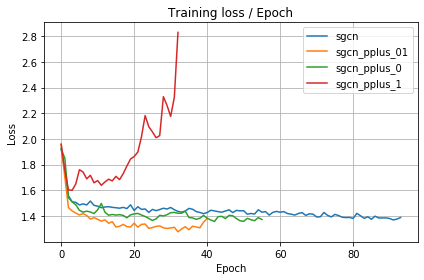

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()
for key, values in results.items():
    print(key)
    loss_train, loss_test, loss_train_all, f1, grad_vars, memory_allocated, max_memory_allocated = values
    
    y = loss_train
    
    x = np.arange(len(y))
    axs.plot(x,y,label=key)

plt.title('Training loss / Epoch')
axs.set_xlabel('Epoch')
axs.set_ylabel('Loss')
axs.grid(True)

fig.tight_layout()
plt.legend()

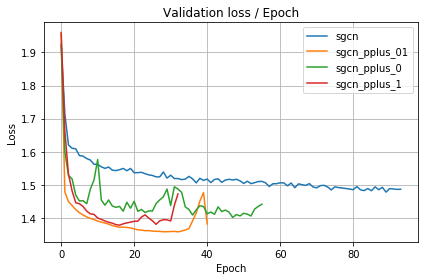

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()
for key, values in results.items():
    loss_train, loss_test, loss_train_all, f1, grad_vars, memory_allocated, max_memory_allocated = values
    
    y = loss_test
    
    x = np.arange(len(y))
    axs.plot(x,y,label=key)

plt.title('Validation loss / Epoch')
axs.set_xlabel('Epoch')
axs.set_ylabel('Loss')
axs.grid(True)

fig.tight_layout()
plt.legend()

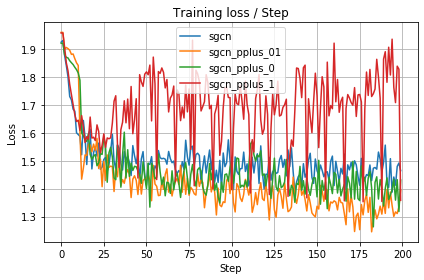

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()
for key, values in results.items():
    loss_train, loss_test, loss_train_all, f1, grad_vars, memory_allocated, max_memory_allocated = values
    
    y = loss_train_all[:200]
    
    x = np.arange(len(y))
    axs.plot(x,y,label=key)

plt.title('Training loss / Step')
axs.set_xlabel('Step')
axs.set_ylabel('Loss')
axs.grid(True)

fig.tight_layout()
plt.legend()

In [22]:
for key, values in results.items():
    loss_train, loss_test, loss_train_all, f1, grad_vars, memory_allocated, max_memory_allocated = values
    print(key, f1)

sgcn 0.4961233361717384
sgcn_pplus_01 0.5197418545242684
sgcn_pplus_0 0.5045041007484427
sgcn_pplus_1 0.5087617084210998


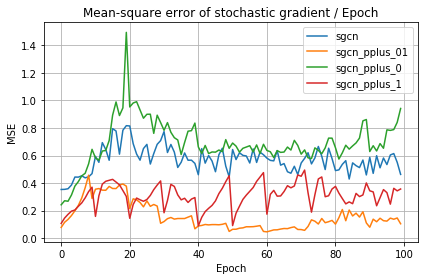

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()
for key, values in results.items():
    loss_train, loss_test, loss_train_all, f1, grad_vars, memory_allocated, max_memory_allocated = values
    
    y = grad_vars[:100]
    
    x = np.arange(len(y))
    axs.plot(x,y,label=key)

plt.title('Mean-square error of stochastic gradient / Epoch')
axs.set_xlabel('Epoch')
axs.set_ylabel('MSE')
axs.grid(True)

fig.tight_layout()
plt.legend()

## WARNING!!! 
MAKE SURE `calculate_grad_vars=False` when calculating the when analysing the GPU memory

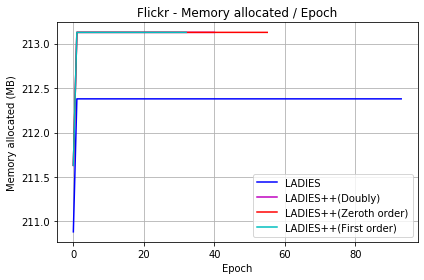

In [25]:
def name_trans(key, method):
    if method=='ladies':
        method='LADIES'
    name_trans = {'sgcn':'{}'.format(method), 
                  'sgcn_plus':'{}+'.format(method), 
                  'sgcn_pplus_0':'{}++(Zeroth order)'.format(method),
                  'sgcn_pplus_1':'{}++(First order)'.format(method), 
                  'sgcn_pplus_01':'{}++(Doubly)'.format(method), 
                  'full':'Full-batch'}
    return name_trans[key]

def color_trans(key):
    color_trans = {'sgcn':'b', 
                  'sgcn_plus':'g', 
                  'sgcn_pplus_0':'r',
                  'sgcn_pplus_1':'c', 
                  'sgcn_pplus_01':'m', 
                  'full':'y'}
    return color_trans[key]

fig, axs = plt.subplots()

for key, values in results.items():
    loss_train, loss_test, loss_train_all, f1, grad_vars, memory_allocated, max_memory_allocated = values
    
    y = memory_allocated
    x = np.arange(len(y))
    axs.plot(x,y,label=name_trans(key,args.sample_method), color=color_trans(key))
    
axs.set_xlabel('Epoch')
axs.set_ylabel('Memory allocated (MB)')
axs.grid(True)

plt.title('Flickr - Memory allocated / Epoch')
fig.tight_layout()
plt.legend()
# plt.savefig('memory_allocated_{}.pdf'.format(args.dataset))
# plt.close()

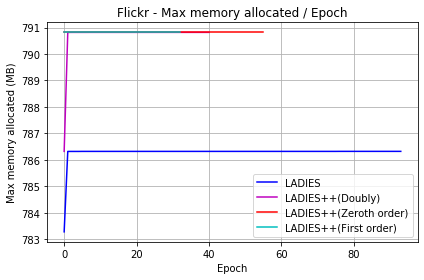

In [26]:


fig, axs = plt.subplots()
for key, values in results.items():
    loss_train, loss_test, loss_train_all, f1, grad_vars, memory_allocated, max_memory_allocated = values
    
    y = max_memory_allocated
    x = np.arange(len(y))
    axs.plot(x,y,label=name_trans(key,args.sample_method), color=color_trans(key))
    
axs.set_xlabel('Epoch')
axs.set_ylabel('Max memory allocated (MB)')
axs.grid(True)

plt.title('Flickr - Max memory allocated / Epoch')
fig.tight_layout()
plt.legend()
# plt.savefig('max_memory_allocated_{}.pdf'.format(args.dataset))
# plt.close()